In [8]:
# Ignore this block -- it's for the documentation build
try:
    import os, sys
    sys.path.insert(1, os.path.abspath('/home/runner/work/psi4/psi4/code/objdir/stage//usr/local/psi4/lib/'))
except ImportError:
    pass

# This is the important part
import psi4

In [9]:
psi4.set_output_file('outputAr.dat', False)

PosixPath('outputAr.dat')

In [10]:
#! Sample HF/cc-pVDZ H2O Computation

psi4.set_memory('500 MB')

h2o = psi4.geometry("""
O
H 1 0.96
H 1 0.96 2 104.5
""")

psi4.energy('scf/cc-pvdz')

-76.0266327350902

In [11]:
#! Sample UHF/6-31G** CH2 Computation

R = 1.075
A = 133.93

ch2 = psi4.geometry("""
0 3
C
H 1 {0}
H 1 {0} 2 {1}
""".format(R, A)
)

psi4.set_options({'reference': 'uhf'})
psi4.energy('scf/6-31g**')

-38.92533462893707

In [12]:
psi4.set_options({'reference': 'rhf'})
psi4.optimize('scf/cc-pvdz', molecule=h2o)

Optimizer: Optimization complete!


-76.02703272937481

In [15]:
scf_e, scf_wfn = psi4.frequency('scf/cc-pvdz', molecule=h2o, return_wfn=True)

In [16]:
dimer = psi4.geometry("""
0 1
C   0.000000  -0.667578  -2.124659
C   0.000000   0.667578  -2.124659
H   0.923621  -1.232253  -2.126185
H  -0.923621  -1.232253  -2.126185
H  -0.923621   1.232253  -2.126185
H   0.923621   1.232253  -2.126185
--
0 1
C   0.000000   0.000000   2.900503
C   0.000000   0.000000   1.693240
H   0.000000   0.000000   0.627352
H   0.000000   0.000000   3.963929
units angstrom
""")

In [17]:
psi4.set_options({'scf_type': 'df',
                  'freeze_core': True})

psi4.energy('sapt0/jun-cc-pvdz', molecule=dimer)

-0.0022355823909805178

In [19]:
#! Example potential energy surface scan and CP-correction for Ar2

Ar2_geometry = """
Ar
--
Ar 1 {0}
"""

Rvals = [3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0]

psi4.set_options({'freeze_core': True})

# Initialize a blank dictionary of counterpoise corrected energies
# (Need this for the syntax below to work)

ecp = {}

for R in Rvals:
    Ar2 = psi4.geometry(Ar2_geometry.format(R))
    ecp[R] = psi4.energy('ccsd(t)/aug-cc-pvdz', bsse_type='cp', molecule=Ar2)

# Prints to screen
print("CP-corrected CCSD(T)/aug-cc-pVDZ Interaction Energies\n\n")
print("          R [Ang]                 E_int [kcal/mol]       ")
print("---------------------------------------------------------")
for R in Rvals:
    e = ecp[R] * psi4.constants.hartree2kcalmol
    print("            {:3.1f}                        {:1.6f}".format(R, e))

# Prints to output.dat
psi4.core.print_out("CP-corrected CCSD(T)/aug-cc-pVDZ Interaction Energies\n\n")
psi4.core.print_out("          R [Ang]                 E_int [kcal/mol]       \n")
psi4.core.print_out("---------------------------------------------------------\n")
for R in Rvals:
    e = ecp[R] * psi4.constants.hartree2kcalmol
    psi4.core.print_out("            {:3.1f}                        {:1.6f}\n".format(R, e))

CP-corrected CCSD(T)/aug-cc-pVDZ Interaction Energies


          R [Ang]                 E_int [kcal/mol]       
---------------------------------------------------------
            3.5                        0.169820
            3.6                        0.037518
            3.7                        -0.042931
            3.8                        -0.089134
            3.9                        -0.113090
            4.0                        -0.122889
            4.1                        -0.123921
            4.2                        -0.119738
            4.3                        -0.112652
            4.4                        -0.104146
            4.5                        -0.095152
            4.6                        -0.086236
            4.7                        -0.077730
            4.8                        -0.069808
            4.9                        -0.062548
            5.0                        -0.055968
            5.1                        -0.0500

Fitted sigma: 3.6417 Å
Fitted epsilon: 0.1201 kcal/mol


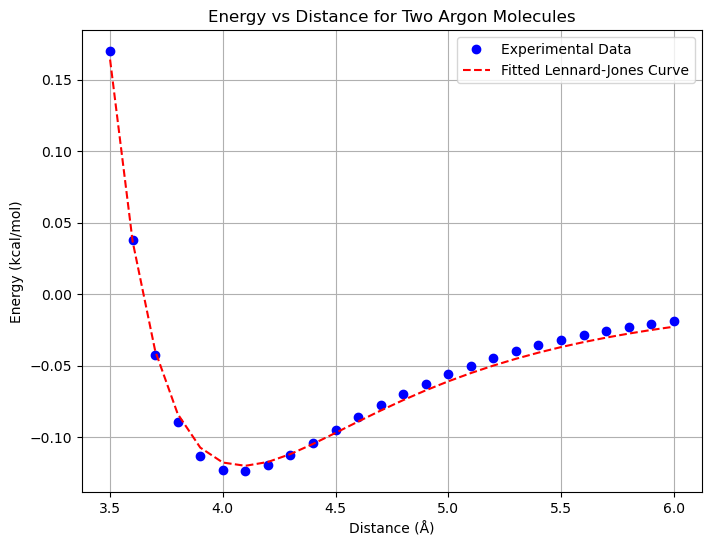

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the Lennard-Jones potential function
def lj(r, sigma, eps):
    return 4 * eps * ((sigma / r) ** 12 - (sigma / r) ** 6)

# Your new data (R in Angstroms and E_int in kcal/mol)
distances = np.array([3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 
                      4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 
                      5.9, 6.0])
energies = np.array([0.169820, 0.037518, -0.042931, -0.089134, -0.113090, -0.122889, 
                     -0.123921, -0.119738, -0.112652, -0.104146, -0.095152, -0.086236, 
                     -0.077730, -0.069808, -0.062548, -0.055968, -0.050049, -0.044753, 
                     -0.040030, -0.035830, -0.032099, -0.028789, -0.025853, -0.023248, 
                     -0.020936, -0.018882])

# Fit the data to the Lennard-Jones potential using curve_fit
# Initial guesses for sigma and epsilon (rough estimates based on the data)
popt, pcov = curve_fit(lj, distances, energies, p0=[3.4, 0.01])

# Extract the fitted parameters sigma and eps
sigma_fit, eps_fit = popt

# Print the fitted parameters
print(f"Fitted sigma: {sigma_fit:.4f} Å")
print(f"Fitted epsilon: {eps_fit:.4f} kcal/mol")

# Plot the data and the fitted curve
plt.figure(figsize=(8, 6))
plt.plot(distances, energies, 'o', label='Experimental Data', markersize=6, color='b')  # Data points
plt.plot(distances, lj(distances, *popt), '--', label=f'Fitted Lennard-Jones Curve', color='r')  # Fitted curve

# Customize the plot
plt.title('Energy vs Distance for Two Argon Molecules')
plt.xlabel('Distance (Å)')
plt.ylabel('Energy (kcal/mol)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
